相似度度量方法：欧氏距离（根号）/曼哈顿距离（绝对值的差的和）

相似度度量指标：余弦相似度、杰卡德相似系数

近邻样本搜寻方法：全表扫描、KD树搜寻法和球树搜寻法

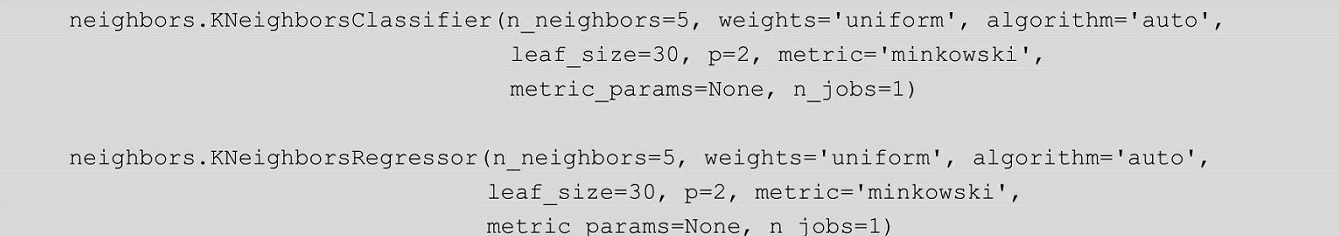

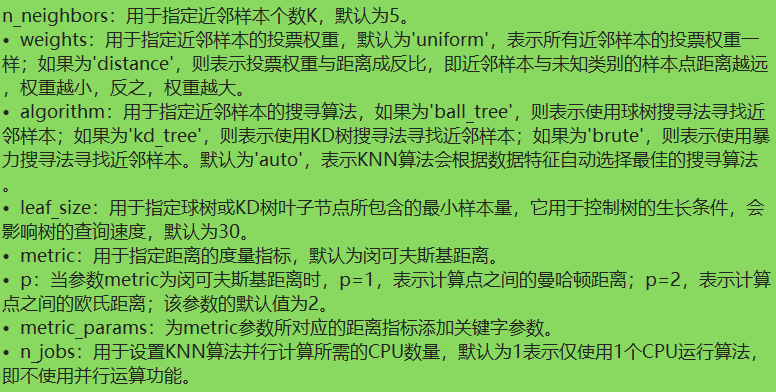

# 分类问题的解决

In [1]:
#导入第三方模块
import pandas as pd
Knowledge = pd.read_excel('Knowledge.xlsx')

In [2]:
Knowledge.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,Very Low
1,0.08,0.08,0.10,0.24,0.90,High
2,0.06,0.06,0.05,0.25,0.33,Low
3,0.10,0.10,0.15,0.65,0.30,Middle
4,0.08,0.08,0.08,0.98,0.24,Low


STG:学习时长，SCG:重复次数,STR:相关科目学习时长，LPR：相关科目考试成绩，PEG：目标科目考试成绩 UNS：学生对知识掌握程度高低分类

In [3]:
predictors = Knowledge.columns[:-1]
predictors

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG'], dtype='object')

In [4]:
from sklearn import model_selection
X_train,X_test,y_train,y_test = model_selection.train_test_split(Knowledge[predictors],Knowledge.UNS,test_size = 0.25,random_state=1234)

分好测试集和训练集后要用多重交叉验证得到理想的近邻个数k

In [5]:
import numpy as np
from sklearn import neighbors
import matplotlib.pyplot as plt

In [6]:
#设置待测试的不同k值
K = np.arange(1,np.ceil(np.log2(Knowledge.shape[0])))  #有400多行，log2（400）大概是8点多，ceil向上取整取到9
K

array([1., 2., 3., 4., 5., 6., 7., 8.])

In [7]:
accuracy = []
for k in K:
    #使用10重交叉验证法
    cv_result = model_selection.cross_val_score(neighbors.KNeighborsClassifier(n_neighbors=int(k),weights = 'distance'),X_train,y_train,cv=10,scoring='accuracy')
    accuracy.append(cv_result.mean())

In [8]:
#从k个平均准确率中挑选出最大值所对应的下标
arg_max = np.array(accuracy).argmax()

In [9]:
#中文和负号的正常显示
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

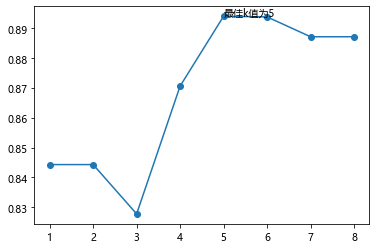

In [10]:
#绘制不同K值与平均预测准确率之间的折线图
plt.plot(K,accuracy)
#添加点图
plt.scatter(K,accuracy)
#添加文字说明
plt.text(K[arg_max],accuracy[arg_max],'最佳k值为%s'%int(K[arg_max]))
plt.show()

## 建模

In [12]:
knn_class = neighbors.KNeighborsClassifier(n_neighbors = 5,weights = 'distance')

#模型拟合
knn_class.fit(X_train,y_train)

#模型在测试数据集上预测
predict = knn_class.predict(X_test)

#构建混淆矩阵
cm = pd.crosstab(predict,y_test)
cm

UNS,High,Low,Middle,Very Low
row_0,,,,
High,29,0,0,0
Low,0,34,3,5
Middle,1,0,23,0
Very Low,0,0,0,6


把这个混淆矩阵左乘热力图

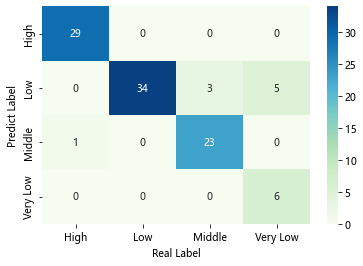

In [13]:
import seaborn as sns

#把混淆矩阵构造成数据框，加上字段名和行名称
cm = pd.DataFrame(cm,columns = ['High','Low','Middle','Very Low'],index =['High','Low','Middle','Very Low'] )

#绘制热力图
sns.heatmap(cm,annot=True,cmap='GnBu')
plt.xlabel('Real Label')
plt.ylabel('Predict Label')

plt.show()

In [19]:
Knowledge.value_counts("UNS")

UNS
Low         129
Middle      122
High        102
Very Low     50
dtype: int64

In [20]:
y_test.value_counts("UNS")

Low         0.336634
High        0.297030
Middle      0.257426
Very Low    0.108911
Name: UNS, dtype: float64

预测High有29个，实际为High的有30个

得到模型在测试集上的预测准确率

In [26]:
from sklearn import metrics

metrics.accuracy_score(y_test,predict)

0.9108910891089109

该指标只能衡量模型的整体预测效果，无法对比每个类别的预测精度、覆盖率等信息

In [27]:
print(metrics.classification_report(y_test,predict))

              precision    recall  f1-score   support

        High       1.00      0.97      0.98        30
         Low       0.81      1.00      0.89        34
      Middle       0.96      0.88      0.92        26
    Very Low       1.00      0.55      0.71        11

    accuracy                           0.91       101
   macro avg       0.94      0.85      0.88       101
weighted avg       0.93      0.91      0.91       101



precision是预测精度，recall是预测覆盖率,f1-score是对precision和recall加权所得，第四列为类别实际样本个数

# 预测问题解决

In [29]:
ccpp = pd.read_excel('CCPP.xlsx')
ccpp.shape

(9568, 5)

In [30]:
ccpp.head(5)

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


AT表示高炉温度，V表示炉内压力，AP表示高炉相对湿度，RH表示高炉排气量，最后一列PE为连续性的因变量，表示高炉的发电量

因为四个自变量的量纲不一致，所以对其做标准化处理

In [34]:
from sklearn.preprocessing import minmax_scale
#对所有自变量数据做标准化处理
predictors = ccpp.columns[:-1]
X = minmax_scale(ccpp[predictors])
X

array([[0.37252125, 0.29181495, 0.77159119, 0.63820375],
       [0.66203966, 0.66903915, 0.6718634 , 0.44932976],
       [0.09348442, 0.24982206, 0.47686216, 0.8924933 ],
       ...,
       [0.83597734, 0.87135231, 0.49566939, 0.1463807 ],
       [0.64220963, 0.78451957, 0.51893096, 0.49369973],
       [0.56062323, 0.66120996, 0.60232616, 0.56715818]])

In [36]:
K = np.arange(1,np.ceil(np.log2(ccpp.shape[0])))

做预测时不用准确率而使用MSE

In [37]:
X_train,X_test,y_train,y_test = model_selection.train_test_split(ccpp[predictors],ccpp.PE,test_size=0.25,random_state=1234)

In [39]:
mse = []
for k in K:
    cv_result = model_selection.cross_val_score(neighbors.KNeighborsRegressor(n_neighbors = int(k),weights = 'distance'),X_train,y_train,cv=10,scoring='neg_mean_squared_error')
    mse.append((-1*cv_result).mean())

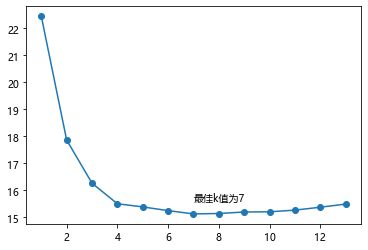

In [41]:
#从k个平均MSE中挑选出最小值所对应的下标
arg_min = np.array(mse).argmin()
#绘制不同K值与平均MSE之间的折线图
plt.plot(K,mse)
plt.scatter(K,mse)
plt.text(K[arg_min],mse[arg_min] + 0.5,'最佳k值为%s'%int(K[arg_min]))

plt.show()

In [42]:
#重新构建模型，取n_neighbors为7
knn_reg = neighbors.KNeighborsRegressor(n_neighbors=7,weights = 'distance')

#模型拟合
knn_reg.fit(X_train,y_train)

#模型再测试集上的预测
predict = knn_reg.predict(X_test)

#计算MSE值
metrics.mean_squared_error(y_test,predict)

14.317278944570017

这边可能看不出什么东西，所以对比一下真实值和实际值

In [43]:
pd.DataFrame({'Real':y_test,'Predict':predict},columns = ['Real','Predict']).head(10)

,Real,Predict
2620,435.68,437.266781
6998,442.90,442.514174
2857,449.01,449.052276
6510,449.75,445.588047
5368,455.20,449.651779
3486,453.49,455.120328
6251,479.14,475.440808
5548,446.71,442.798681
2266,429.80,431.654823
5615,474.40,474.400000


可以发现拟合的效果还是非常理想的

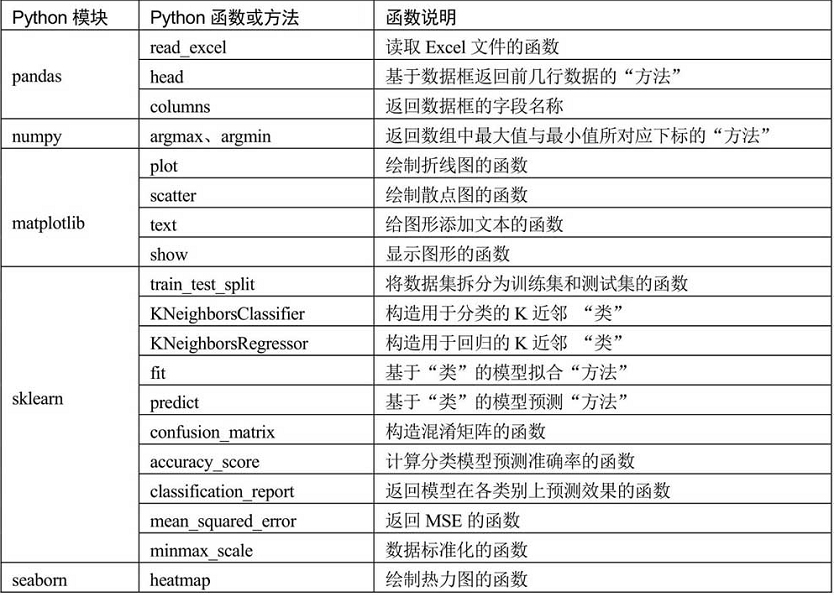